In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import numpy as np

# Pad naar de dataset
data_dir = "idc_regular"

# Functie om de dataset in te laden
def load_data(data_dir):
    data = []
    for patient_dir in os.listdir(data_dir):
        patient_path = os.path.join(data_dir, patient_dir)
        if os.path.isdir(patient_path):
            for label in ['0', '1']:
                label_dir = os.path.join(patient_path, label)
                for file in os.listdir(label_dir):
                    if file.endswith('.png'):
                        file_path = os.path.join(label_dir, file)
                        data.append({
                            'patient': patient_dir,
                            'label': int(label),
                            'file_path': file_path
                        })
    return pd.DataFrame(data)

# Data inladen
df = load_data(data_dir)
print(f"Data geladen: {len(df)} rijen")
print(df.head())

# Controleer op missende waarden
missing_values = df.isnull().sum()
print("Missende waarden per kolom:")
print(missing_values)


Data geladen: 277524 rijen
  patient  label                                          file_path
0   10253      0  idc_regular\10253\0\10253_idx5_x1001_y1001_cla...
1   10253      0  idc_regular\10253\0\10253_idx5_x1001_y1051_cla...
2   10253      0  idc_regular\10253\0\10253_idx5_x1001_y1101_cla...
3   10253      0  idc_regular\10253\0\10253_idx5_x1001_y1151_cla...
4   10253      0  idc_regular\10253\0\10253_idx5_x1001_y1201_cla...
Missende waarden per kolom:
patient      0
label        0
file_path    0
dtype: int64


Uitsneden per klasse:
label
0    198738
1     78786
Name: count, dtype: int64
Verhouding tussen klassen:
label
0    71.611104
1    28.388896
Name: count, dtype: float64
         Gezond (%)  Ongezond (%)
patient                          
10253     87.249545     12.750455
10254     91.037736      8.962264
10255     66.544118     33.455882
10256     75.000000     25.000000
10257     67.244094     32.755906


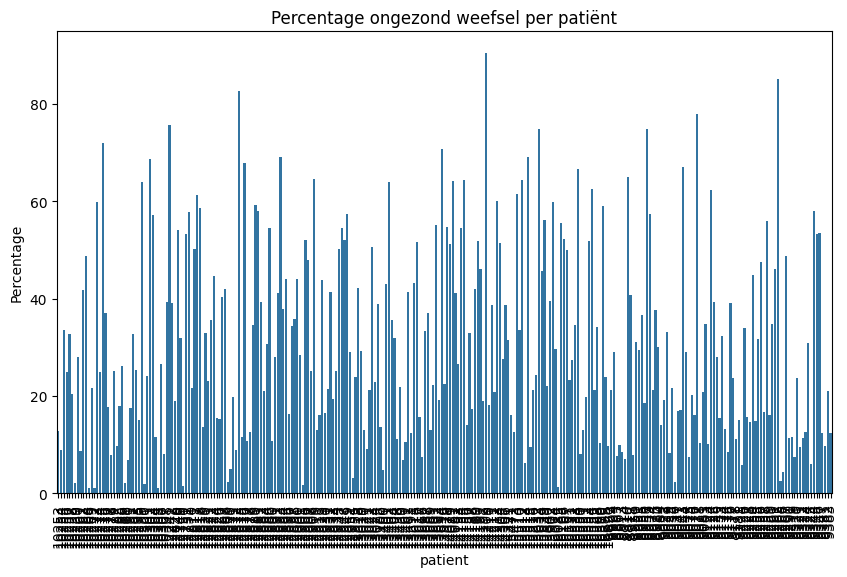

In [2]:
# Aantal uitsneden per klasse
counts = df['label'].value_counts()
print(f"Uitsneden per klasse:\n{counts}")

# Verhouding tussen gezond en ongezond weefsel
total = len(df)
percentages = counts / total * 100
print(f"Verhouding tussen klassen:\n{percentages}")

# Percentage ongezond weefsel per patiënt
patient_stats = df.groupby('patient')['label'].value_counts(normalize=True).unstack().fillna(0)
patient_stats.columns = ['Gezond (%)', 'Ongezond (%)']
patient_stats *= 100
print(patient_stats.head())

# Visualisatie van ongezond weefsel per patiënt
plt.figure(figsize=(10, 6))
sns.barplot(x=patient_stats.index, y=patient_stats['Ongezond (%)'])
plt.xticks(rotation=90)
plt.title("Percentage ongezond weefsel per patiënt")
plt.ylabel("Percentage")
plt.show()


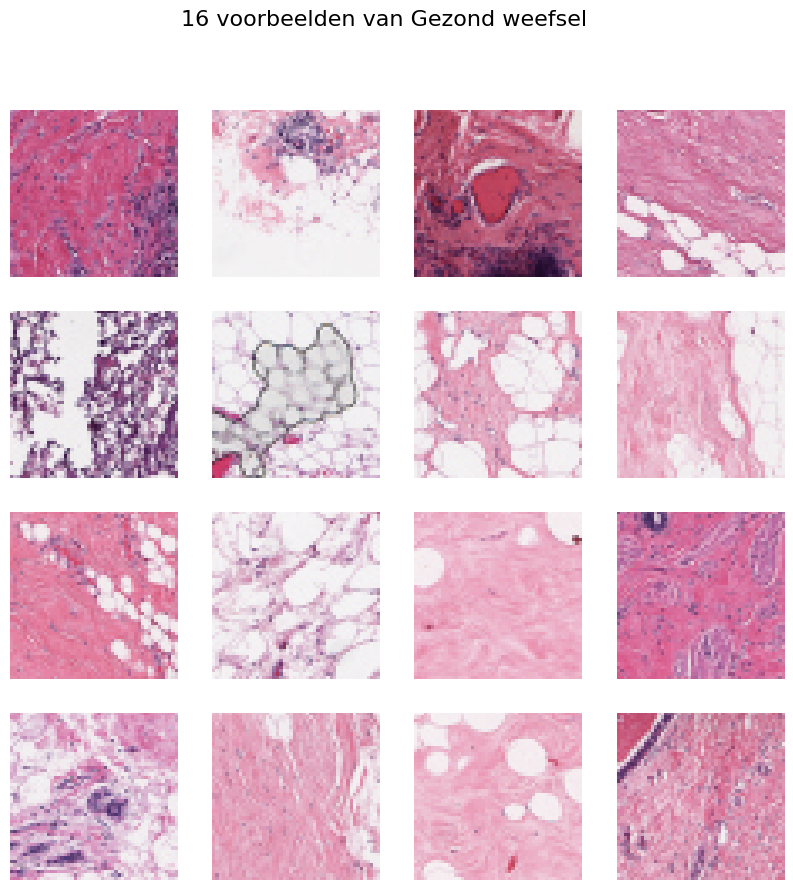

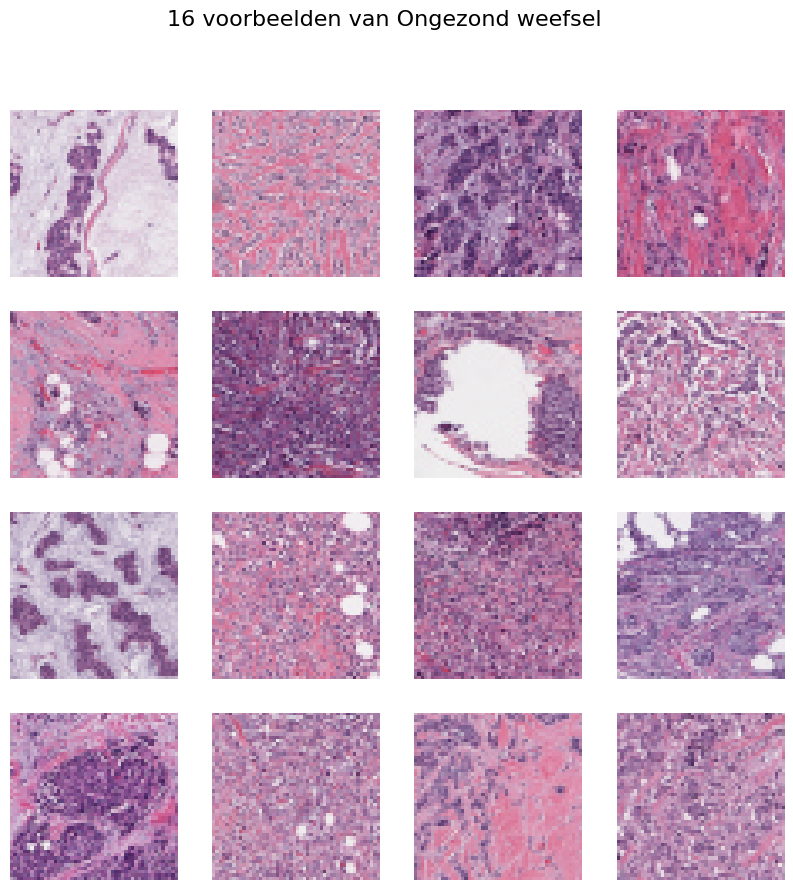

In [3]:
# Functie om afbeeldingen te tonen
def plot_samples(df, label, n=16):
    samples = df[df['label'] == label].sample(n)
    plt.figure(figsize=(10, 10))
    for i, file_path in enumerate(samples['file_path']):
        plt.subplot(4, 4, i + 1)
        img = Image.open(file_path)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    plt.suptitle(f"{n} voorbeelden van {'Ongezond' if label == 1 else 'Gezond'} weefsel", fontsize=16)
    plt.show()

# Toon voorbeelden
plot_samples(df, label=0, n=16)  # Gezond
plot_samples(df, label=1, n=16)  # Ongezond



In [6]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import numpy as np
import pandas as pd
from PIL import Image

# Functie om een subset van de data te nemen
def sample_data(df, fraction=0.1):
    return df.sample(frac=fraction, random_state=42)

# Neem slechts 10% van de data
df_sampled = sample_data(df, fraction=0.1)

# Functie om horizontaal te splitsen
def split_data_horizontal(df):
    patients = df['patient'].unique()
    train_patients, test_patients = train_test_split(patients, test_size=0.2, random_state=42)
    train_df = df[df['patient'].isin(train_patients)]
    test_df = df[df['patient'].isin(test_patients)]
    return train_df, test_df

# Data splitsen
train_df, test_df = split_data_horizontal(df_sampled)

# Functie om data en labels te laden
def load_images(df):
    images = []
    labels = []
    for _, row in df.iterrows():
        img = Image.open(row['file_path']).resize((50, 50))  # Rescale naar 50x50 pixels
        images.append(np.array(img) / 255.0)  # Normaliseer
        labels.append(row['label'])
    return np.array(images), np.array(labels)

# Laad trainings- en testdata
x_train, y_train = load_images(train_df)
x_test, y_test = load_images(test_df)

# Labels naar one-hot encoding
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)


In [17]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# 1. Data inladen
data_dir = "idc_regular"
patients = os.listdir(data_dir)

# 2. Dataframe maken
data = []
for patient in patients:
    for label in ['0', '1']:
        path = os.path.join(data_dir, patient, label)
        for file in os.listdir(path):
            x = file.split('_')[2].replace('x', '')  # Verwijder 'x'
            y = file.split('_')[3].replace('y', '')  # Verwijder 'y'
            data.append([patient, int(label), int(x), int(y), os.path.join(path, file)])

df = pd.DataFrame(data, columns=['patient', 'label', 'x', 'y', 'file_path'])

# 3. Neem slechts 1% van de data voor sneller trainen
def sample_data(df, fraction):
    return df.sample(frac=fraction, random_state=42)

df = sample_data(df, fraction=0.01)

# 4. Filter patiënten met minder dan 2 samples
patient_counts = df['patient'].value_counts()
valid_patients = patient_counts[patient_counts > 1].index
df_filtered = df[df['patient'].isin(valid_patients)]

# 5. Data splitsen
train_df, test_df = train_test_split(df_filtered, test_size=0.2, stratify=df_filtered['patient'], random_state=42)

# 6. Data voorbereiden
def load_data(df):
    images, labels = [], []
    for _, row in df.iterrows():
        img = Image.open(row['file_path']).resize((50, 50))
        images.append(np.array(img) / 255.0)  # Normaliseer
        labels.append(row['label'])
    return np.array(images), to_categorical(labels)

x_train, y_train = load_data(train_df)
x_test, y_test = load_data(test_df)

# 7. Model bouwen
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(50, 50, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# 8. Trainen
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=32)

# 9. Evalueren
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")


d:\Rene\Documents\school\kanker_modeleren\.conda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 8s 75ms/step - accuracy: 0.7377 - loss: 0.5499 - val_accuracy: 0.7468 - val_loss: 0.4836
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.7682 - loss: 0.4883 - val_accuracy: 0.7794 - val_loss: 0.4604
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - accuracy: 0.8060 - loss: 0.4545 - val_accuracy: 0.7957 - val_loss: 0.4298
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - accuracy: 0.8125 - loss: 0.4405 - val_accuracy: 0.8174 - val_loss: 0.4125
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - accuracy: 0.8253 - loss: 0.4116 - val_accuracy: 0.7685 - val_loss: 0.4711
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.8032 - loss: 0.4474 - val_accuracy: 0.7722 - val_loss: 0.5079
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - accuracy: 0.7974 - loss: 0.4639 - val_accuracy: 0.8083 - val_loss: 0.4167
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.8239 - loss: 0.4088 - val_accuracy: 0.7812 - 

In [18]:
from PIL import Image
import numpy as np

def predict_image(image_path, model, class_names):
    # Load and preprocess the image
    img = Image.open(image_path).resize((50, 50))  # Resize to 50x50
    img_array = np.array(img) / 255.0  # Normalize
    if len(img_array.shape) == 2:  # If grayscale, add channel dimension
        img_array = np.expand_dims(img_array, axis=-1)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Make prediction
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)[0]

    # Output result
    print(f"Predicted class: {class_names[predicted_class]} ({prediction[0][predicted_class]:.2f} confidence)")

# Example usage
image_path = "healthy.png"  # Replace with the path to your image
class_names = ["Healthy", "Unhealthy"]  # Replace with your actual class names
predict_image(image_path, model, class_names)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
Predicted class: Healthy (0.82 confidence)
